#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
data1 = pd.read_csv(path + '/data01_train.csv')
data1.drop('subject', axis=1, inplace=True)
data1.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


In [6]:
data2 = pd.read_csv(path + '/data01_test.csv')
data2.drop('subject', axis=1, inplace=True)
data2.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


#### 2) 기본 정보 조회

In [7]:
print('train : ', data1.shape)
print('test : ', data2.shape)

train :  (5881, 563)
test :  (1471, 563)


In [8]:
data1.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [9]:
data2.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194,17.539089
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645,9.122876
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000,1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445,8.000000
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243,19.000000
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674,26.000000
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766,30.000000


## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [10]:
model1_data = data1.copy()
model1_data['is_dynamic'] = model1_data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})

### (2) x, y 분리

In [11]:
target = 'is_dynamic'

model1_x = model1_data.drop(['is_dynamic', 'Activity', 'subject'], axis=1)
model1_y = model1_data.loc[:, target]

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [12]:
scaler = MinMaxScaler()
model1_x = scaler.fit_transform(model1_x)

### (4) 데이터 분할
* train, val 분할

In [13]:
model1_x_train, model1_x_val, model1_y_train, model1_y_val = train_test_split(model1_x, model1_y, test_size=.2, random_state = 20)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [14]:
nfeatures = model1_x_train.shape[1]

In [15]:
clear_session()
model1 = Sequential([Input(shape = (nfeatures,)),
                     Dense(1, activation= 'sigmoid')])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │             562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562 (2.20 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9649 - loss: 0.1062 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0072 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9979 - val_loss: 0.0076
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 7.6680e-04
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy

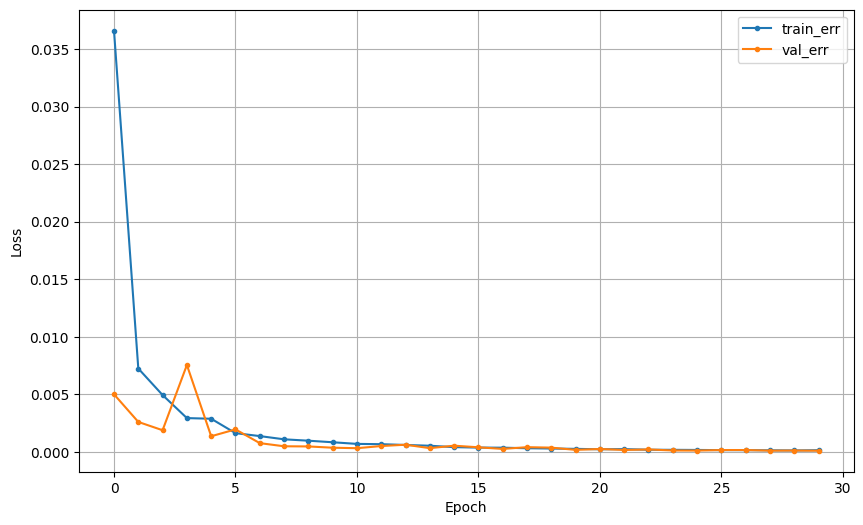

In [16]:
model1.compile(optimizer=Adam(learning_rate=0.008), loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(model1_x_train, model1_y_train, epochs = 30, validation_split=0.2).history
dl_history_plot(history1)

In [17]:
model1_pred1 = model1.predict(model1_x_val)
model1_pred1 = np.where(model1_pred1 >= .5, 1, 0)
print(classification_report(model1_y_val, model1_pred1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       627
           1       1.00      1.00      1.00       550

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류(Laying or (Sitting, Standing))

* 세부 요구사항
    * 정적 행동(Laying or (Sitting, Standing))인 데이터 추출
    * Laying, (Sitting, Standing) 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [18]:
static_model_data = model1_data.loc[model1_data['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])].copy()
static_model_data['Activity'] = static_model_data['Activity'].map({'LAYING':0, 'SITTING':1, 'STANDING':1})

static_model_x = static_model_data.drop(['is_dynamic', 'Activity', 'subject'], axis=1)
static_model_y = static_model_data.loc[:, 'Activity']

scaler = MinMaxScaler()
static_model_x = scaler.fit_transform(static_model_x)

In [19]:
static_model_x_train, static_model_x_val, static_model_y_train, static_model_y_val = train_test_split(static_model_x, static_model_y, test_size=.2, random_state = 20)

In [20]:
nfeatures = static_model_x_train.shape[1]

clear_session()

model2 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(64, activation='relu'),
    Dropout(0.01),
    Dense(64, activation='relu'),
    Dropout(0.01),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          35,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,809 (167.22 KB)

 Trainable params: 42,809 (167.22 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6759 - loss: 0.5822 - val_accuracy: 0.9826 - val_loss: 0.0992
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9745 - loss: 0.0827 - val_accuracy: 0.9942 - val_loss: 0.0144
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9944 - loss: 0.0191 - val_accuracy: 0.9961 - val_loss: 0.0069
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9956 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0062 - val_accuracy: 0.9961 - val_loss: 0.0040
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - loss: 0.0079 - val_accuracy: 0.9961 - val_loss: 0.0080
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5040e-04 - val_accuracy: 1.0000 - val_

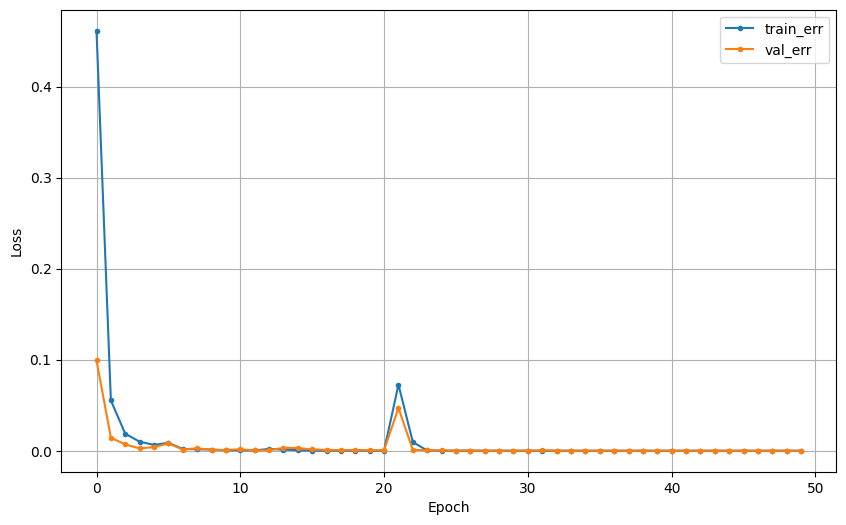

In [21]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(static_model_x_train, static_model_y_train, epochs=50, validation_split=.2, callbacks=[]).history
dl_history_plot(history2)

In [22]:
static_model_pred = model2.predict(static_model_x_val)
static_model_pred_1 = np.where(static_model_pred >= .5, 1, 0)
print(confusion_matrix(static_model_y_val, static_model_pred_1))
print(classification_report(static_model_y_val, static_model_pred_1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[224   0]
 [  0 423]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       224
           1       1.00      1.00      1.00       423

    accuracy                           1.00       647
   macro avg       1.00      1.00      1.00       647
weighted avg       1.00      1.00      1.00       647



#### 1) 단계2-1-2 : 정적 동작 세부 분류2(SITTING, STANDING 구분 모델)

* 세부 요구사항
    * 정적 행동에서(Sitting, Standing)인 데이터 추출
    * Sitting, Standing 를 분류하는 모델을 생성


In [23]:
static_b_model_data = model1_data.loc[model1_data['Activity'].isin(['SITTING', 'STANDING'])].copy()
static_b_model_data['Activity'] = static_b_model_data['Activity'].map({'SITTING':0, 'STANDING':1})

static_b_model_x = static_b_model_data.drop(['is_dynamic', 'Activity'], axis=1)
static_b_model_x = pd.get_dummies(static_b_model_x, columns=['subject'], dtype = int)
static_b_model_y = static_b_model_data.loc[:, 'Activity']

scaler = MinMaxScaler()
static_b_model_x = scaler.fit_transform(static_b_model_x)

In [24]:
static_b_model_x_train, static_b_model_x_val, static_b_model_y_train, static_b_model_y_val = train_test_split(static_b_model_x, static_b_model_y, test_size=.2)

In [25]:
clear_session()
nfeatures = static_b_model_x_train.shape[1]

model3 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │          18,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,929 (73.94 KB)

 Trainable params: 18,929 (73.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5595 - loss: 0.6723 - val_accuracy: 0.7935 - val_loss: 0.5594
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8217 - loss: 0.5112 - val_accuracy: 0.8938 - val_loss: 0.3685
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8992 - loss: 0.3298 - val_accuracy: 0.9115 - val_loss: 0.2564
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9342 - loss: 0.2097 - val_accuracy: 0.9558 - val_loss: 0.1836
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9551 - loss: 0.1465 - val_accuracy: 0.9558 - val_loss: 0.1572
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9522 - loss: 0.1373 - val_accuracy: 0.9617 - val_loss: 0.1349
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9616 - loss: 0.1158 - val_accuracy: 0.9440 - val_loss: 0.1540
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9636 - loss: 0.1111 - val_accuracy: 0.9735 - val_loss:

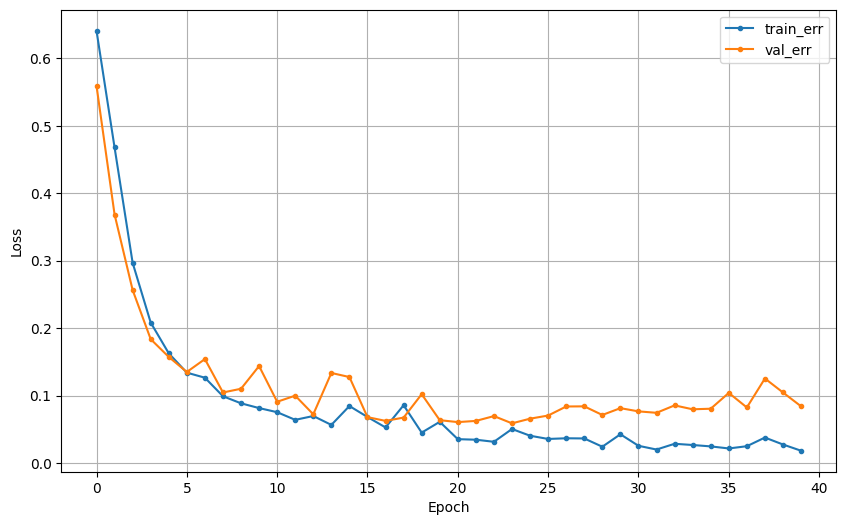

In [26]:
model3.compile(optimizer=Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(static_b_model_x_train, static_b_model_y_train, epochs = 40, validation_split=0.2).history

dl_history_plot(history3)

In [27]:
static_b_model_pred = model3.predict(static_b_model_x_val)
static_b_model_pred = np.where(static_b_model_pred >= .5, 1, 0)
print(classification_report(static_b_model_y_val, static_b_model_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       218
           1       0.98      0.98      0.98       206

    accuracy                           0.98       424
   macro avg       0.98      0.98      0.98       424
weighted avg       0.98      0.98      0.98       424



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [28]:
dynamic_model_data = model1_data.loc[model1_data['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].copy()
dynamic_model_data['Activity'] = dynamic_model_data['Activity'].map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2})

dynamic_model_x = dynamic_model_data.drop(['is_dynamic', 'Activity', 'subject'], axis=1)
dynamic_model_y = dynamic_model_data.loc[:, 'Activity']

scaler = MinMaxScaler()
dynamic_model_x = scaler.fit_transform(dynamic_model_x)

In [29]:
dynamic_model_x_train, dynamic_model_x_val, dynamic_model_y_train, dynamic_model_y_val = train_test_split(dynamic_model_x, dynamic_model_y, test_size=.2, random_state = 20)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 3)                   │           1,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7309 - val_loss: 0.2407
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1955 - val_loss: 0.1731
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1393 - val_loss: 0.1213
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0994 - val_loss: 0.1086
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0832 - val_loss: 0.0853
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0660 - val_loss: 0.0774
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0677 - val_loss: 0.0735
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0594 - val_loss: 0.0700
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0522 - val_loss: 0.0631
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - val_loss: 0.0942
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0537 - val_loss: 0.0569
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - val_lo

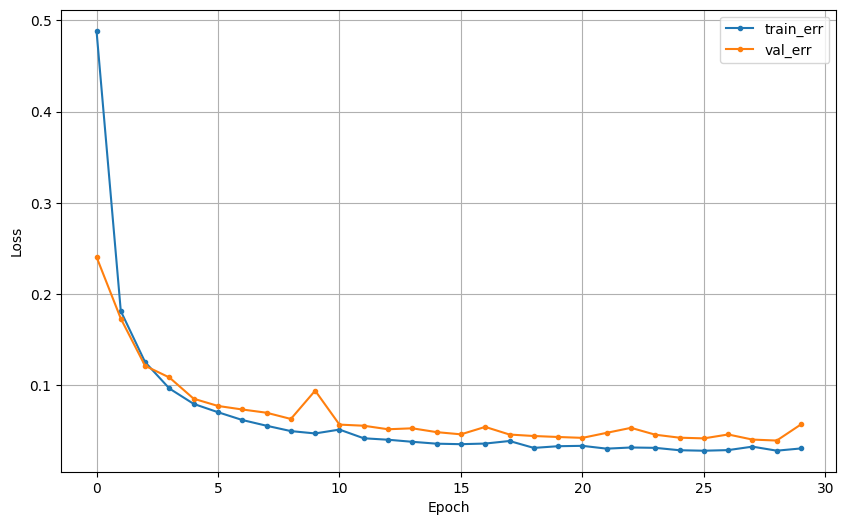

In [30]:
nfeatures = dynamic_model_x_train.shape[1]

clear_session()
model4 = Sequential([Input(shape = (nfeatures,)),
                     Dense(3, activation = 'softmax', kernel_regularizer=l2(0.0001))])
model4.summary()

model4.compile(optimizer=Adam(learning_rate=0.01), loss= 'sparse_categorical_crossentropy')
history4 = model4.fit(dynamic_model_x_train, dynamic_model_y_train, epochs = 30, validation_split=0.2).history
dl_history_plot(history4)

In [31]:
dynamic_model_pred = model4.predict(dynamic_model_x_val)
dynamic_model_pred_1 = dynamic_model_pred.argmax(axis=1)
print(classification_report(dynamic_model_y_val, dynamic_model_pred_1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       199
           1       0.99      0.98      0.99       175
           2       0.99      0.99      0.99       156

    accuracy                           0.98       530
   macro avg       0.99      0.98      0.99       530
weighted avg       0.99      0.98      0.98       530



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

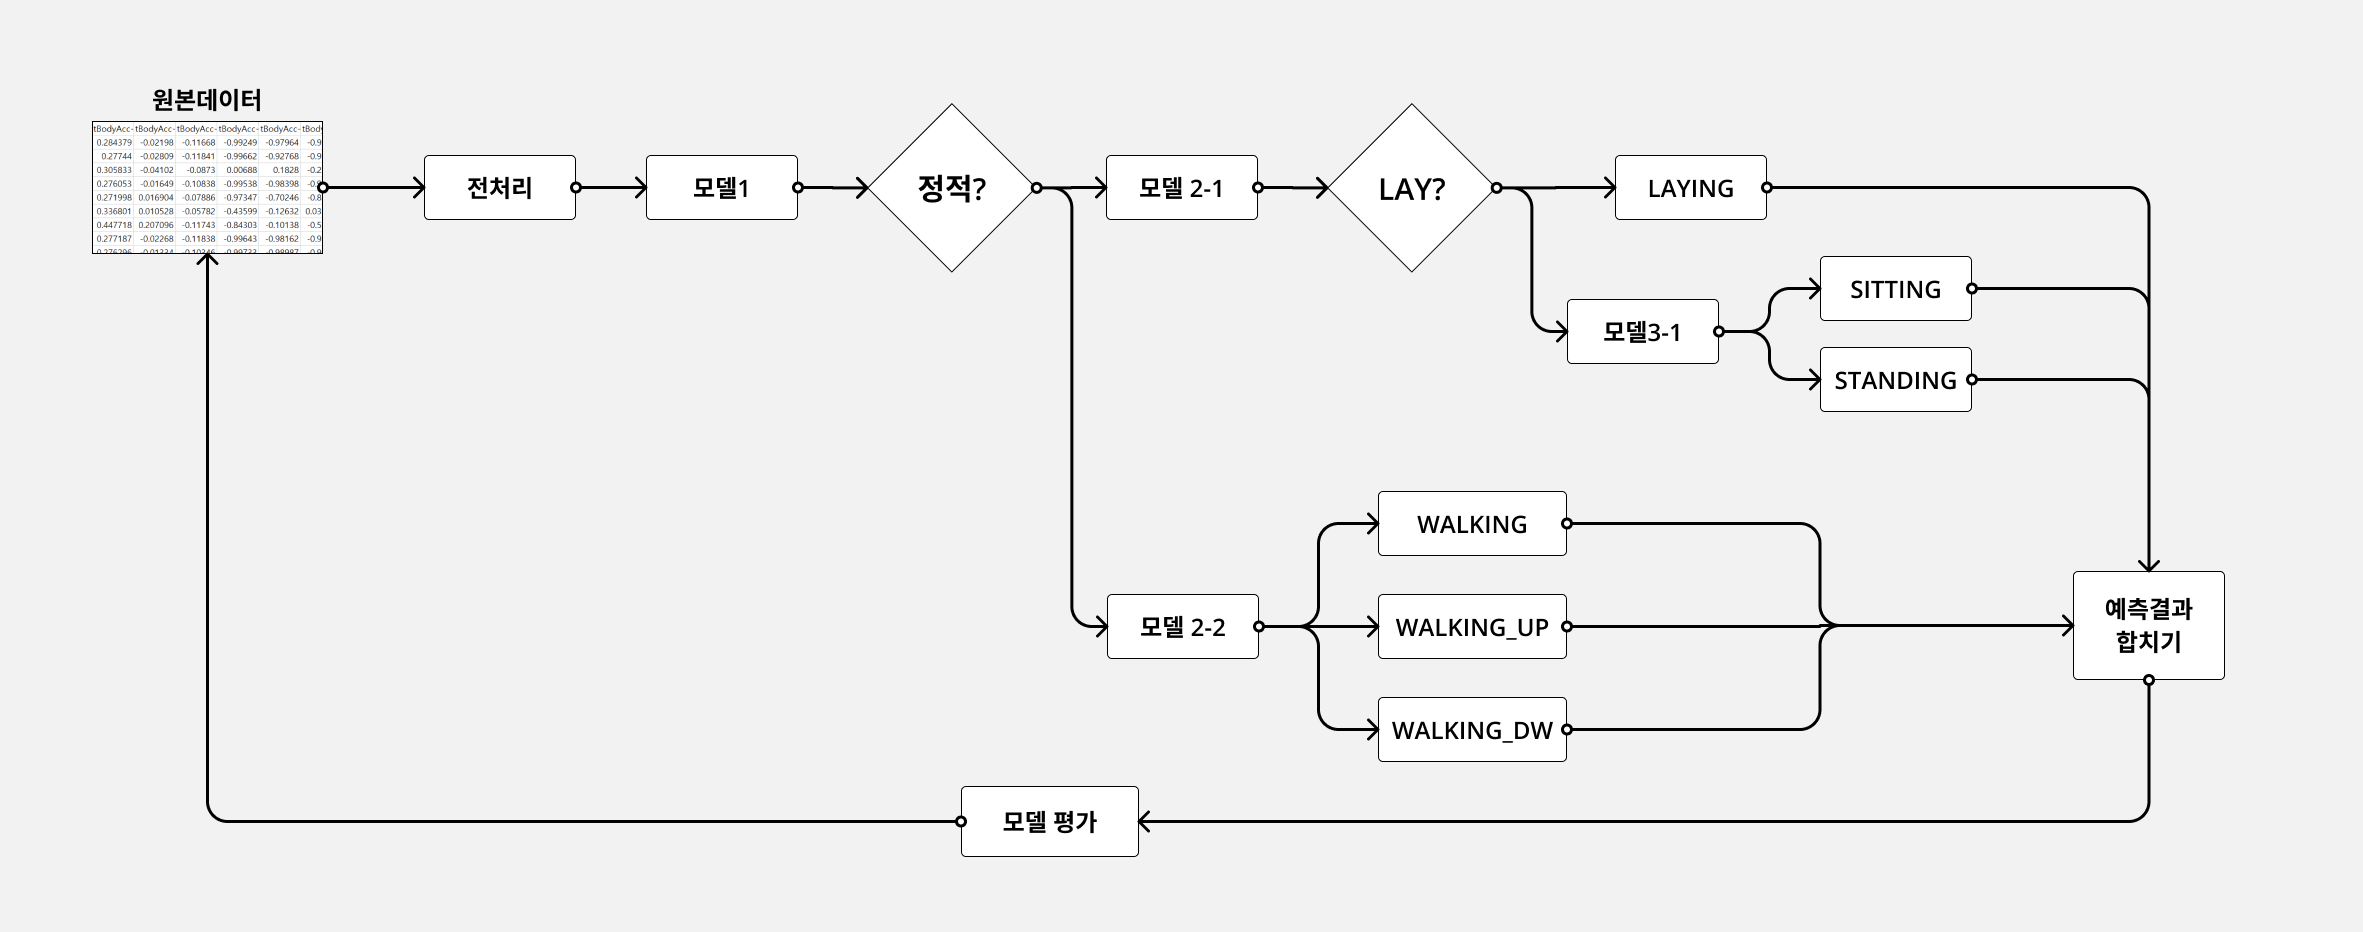

#### 1) 함수 만들기

In [32]:
def model_pipeline(model_data, models=[model1, model2, model3, model4]):
    m_data = model_data.copy()

    t_x2 = model_data.drop(['is_dynamic', 'Activity'], axis=1)
    t_x1 = model_data.drop(['is_dynamic', 'Activity', 'subject'], axis=1)
    t_y1 = model_data.loc[:, 'is_dynamic']
    t_y2 = model_data.loc[:, 'Activity']

    scaler = MinMaxScaler()
    t_x1 = scaler.fit_transform(t_x1)

    pred1 = model1.predict(t_x1)
    pred1 = np.where(pred1 >= .5, 1, 0)

    dynamic_x1 = t_x1[pred1.flatten() == 1]
    dynamic_y1 = t_y2[pred1.flatten() == 1]

    static_x1 = t_x1[pred1.flatten() == 0]
    static_x2 = t_x2[pred1.flatten() == 0]
    static_y1 = t_y2[pred1.flatten() == 0]

    static_pred1 = model2.predict(static_x1)
    static_pred1 = np.where(static_pred1 >= .5, 1, 0)

    static_b_x1 = static_x1[static_pred1.flatten() == 0]
    static_b_x2 = static_x2[static_pred1.flatten() == 1]
    static_b_y1 = static_y1[static_pred1.flatten() == 0]
    static_b_y2 = static_y1[static_pred1.flatten() == 1]


    static_b_pred1_1 = static_pred1[static_pred1.flatten() == 0]
    static_b_x2 = pd.get_dummies(static_b_x2, columns=['subject'], dtype = int)
    static_b_pred1_2 = model3.predict(static_b_x2)
    static_b_pred1_2 = np.where(static_b_pred1_2 >= .5, 2, 1)


    dynamic_pred1 = model4.predict(dynamic_x1)
    dynamic_pred_1 = dynamic_pred1.argmax(axis=1) + 3


    total_pred = np.concatenate((static_b_pred1_1.flatten(), static_b_pred1_2.flatten()), axis=0)
    total_pred = np.concatenate((total_pred, dynamic_pred_1), axis=0)
    total_y1 = pd.concat([static_b_y1, static_b_y2], axis = 0, join = 'outer')
    total_y1 = pd.concat([total_y1, dynamic_y1], axis = 0, join = 'outer')

    print(confusion_matrix(total_pred, total_y1))
    print(classification_report(total_pred, total_y1))


In [33]:
def data_pipeline(test_data):
    temp = test_data.copy()
    temp['is_dynamic'] = temp['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0, 'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
    temp['Activity'] = temp['Activity'].map({'LAYING':0, 'SITTING':1, 'STANDING':2, 'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})

    model_pipeline(temp)


#### 2) test 셋으로 예측하고 평가하기

In [34]:
test_data = data2.copy()
data_pipeline(test_data)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[292   0   0   0   0   0]
 [  0 237  10   0   0   0]
 [  0  17 277   0   0   0]
 [  0   0   0 228  15   0]
 [  0   0   0   0 197   0]
 [  0   0   0   0   3 195]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.93      0.96      0.95       247
           2       0.97      0.94      0.95       294
           3       1.00      0.94      0.97       243
           4       0.92      1.00      0.96       197
           5       1.00      0.98      0.99       198

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

